# Imports

In [1]:
from concurrent.futures import ThreadPoolExecutor
import os
from pathlib import Path
from typing import Optional
from src.data.paths import project_dir
from src.data.analysis import Circle, get_mean_std, get_timestamp, create_circular_mask

import numpy as np
import numpy.typing as npt
from scipy import ndimage
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
from matplotlib.patches import Circle as CirclePatch

In [2]:
from typing import List
def read_df(path : Path , det_names : List[str], analysis_radius : float = 300) -> pd.DataFrame:
    df = pd.DataFrame()
    df["det_id"] = det_names
    df.det_id = df.det_id.astype('uint8')
    df["raw_data"] = df.det_id.apply(lambda id: np.load(path / f"{id}" / "raw.npy"))
    df["timestamp"] = df.det_id.apply(lambda id: get_timestamp(path / f"{id}" / "metadata.txt"))
    df["det_circle"] = df.det_id.apply(lambda x: Circle.from_json(path / f"{x}lv" / "det-circle.json"))
    df["det_angle"] = df.det_id.apply(lambda id: np.load(path / f"{id}lv" / "angle.npy"))
    df["raw_mean_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[0], axis=1)
    df["raw_std_center"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.det_circle)[1], axis=1)

    df['analysis_circle'] = df.det_circle.apply(lambda c: Circle(c.x, c.y, analysis_radius))
    df["raw_mean"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[0], axis=1)
    df["raw_std"] = df.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data, tmpdf.analysis_circle)[1], axis=1)
    return df

In [3]:
import matplotlib as mpl
mpl.rcParams['axes.grid.which'] = 'minor'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['figure.figsize'] = (10, 12)
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

# Figure 4 depth dose

In [4]:
from src.data.analysis import perc_error_to_ref_df

df_bp_exp = pd.read_hdf("article-plots.h5", key="bp_exp")
df_bp_mc = pd.read_hdf("article-plots.h5", key="bp_mc")

df_bp_mc_err = perc_error_to_ref_df(df=df_bp_mc, xcolname='z_mm', ycolname='dose', ref_df=df_bp_exp, ref_xcolname='Depth', ref_ycolname='Signal', threshold=0.1)

''

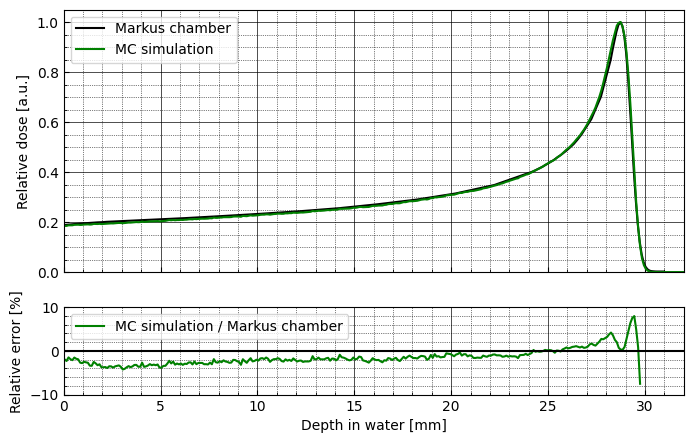

In [5]:
fig, (ax_up, ax_down) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,5))
df_bp_exp.plot(ax=ax_up, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax_up, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax_up.set_ylim(0,1.05)
ax_up.set_ylabel("Relative dose [a.u.]");
# TODO add range annotation

df_bp_mc_err.plot(ax=ax_down, x='z', y='perc_err', label='MC simulation / Markus chamber', color='green', style='-')
ax_down.axhline(y=0., color='black')
ax_down.set_ylim(-10,10)
ax_down.set_xlabel("Depth in water [mm]")
ax_down.set_ylabel("Relative error [%]")
for ax in (ax_up, ax_down):
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    ax.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)
    ax.set_xlim(0,32)
;

# Figure 6 - BP

In [6]:
pre_irr_bg = project_dir / "data" / "interim" / "foils" / "2022_11_23_background"
pre_irr_bg_ids = sorted((entry.name for entry in pre_irr_bg.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_pre_bg = read_df(pre_irr_bg, pre_irr_bg_ids)

In [7]:
data_co60 = project_dir / "data" / "interim" / "foils" / "2022_11_23_Co60"
data_co60_ids = sorted((entry.name for entry in data_co60.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_Co60 = read_df(data_co60, data_co60_ids)

In [8]:
ff_image_path = project_dir / "data" / "interim" / "foils" / "2022_08_22_flat_field" / "FF_2sLED_U340" / "FF_1" / "raw.npy"
ff_data = np.load(ff_image_path)

In [9]:
data_bp = project_dir / "data" / "interim" / "foils" / "2022_11_17_bp"
data_bp_ids = sorted((entry.name for entry in data_bp.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_bp = read_df(data_bp, data_bp_ids)

In [10]:
# apply correction for sensor stability as function of time
x = df_pre_bg.timestamp.apply(lambda x: (x - df_pre_bg.timestamp.min()).total_seconds()).values
y = df_pre_bg.raw_mean_center.values
a,b = np.polyfit(x, y, 1)
print(f"a = {a}, b = {b}")

df_pre_bg["raw_data_stabilised"] = df_pre_bg.apply(lambda x: x.raw_data - a * (x.timestamp - df_pre_bg.timestamp.min()).total_seconds() , axis=1)
df_Co60["raw_data_stabilised"] = df_Co60.apply(lambda x: x.raw_data , axis=1)
df_bp["raw_data_stabilised"] = df_bp.apply(lambda x: x.raw_data - a * (x.timestamp - df_bp.timestamp.min()).total_seconds() , axis=1)

df_pre_bg["raw_mean_stabilized"] = df_pre_bg.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_Co60["raw_mean_stabilized"] = df_Co60.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)
df_bp["raw_mean_stabilized"] = df_bp.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)

a = 0.001687053830354033, b = 1039.8119645231088


In [11]:
def singal_df(df_data : pd.DataFrame, df_bg : pd.DataFrame, ff_array : Optional[npt.NDArray] = None, analysis_radius : float = 300) -> pd.DataFrame:
    df_signal = df_data.copy()
    df_signal.set_index("det_id", inplace=True)

    # remove background
    df_bg.set_index("det_id", inplace=True)
    df_signal["bg_sub"] = df_signal.raw_data - df_bg.raw_data
    df_signal["bg_sub_stabilized"] = df_signal.raw_data_stabilised - df_bg.raw_data_stabilised
    df_bg.reset_index(inplace=True)

    # apply FF
    df_signal["sensor_corr"] = df_signal.bg_sub_stabilized
    if ff_array is not None:
        big_circle = Circle(x=ff_array.shape[1]/2, y=ff_array.shape[0]/2, r=ff_array.shape[1]/2-10)
        mask = create_circular_mask(img=ff_data, circle_px=big_circle)
        gain =  ff_array / np.mean(ff_array[mask])
        df_signal["sensor_corr"] = df_signal.bg_sub_stabilized.apply(lambda x: x / gain)
        
    # move to center, faster version using multiple threads
    no_of_cpus = os.cpu_count()
    if no_of_cpus is None:
        no_of_cpus = 1
    def shift(data: npt.NDArray, x : float, y : float) -> npt.NDArray:
        return ndimage.shift(data, (data.shape[1]/2-y,data.shape[0]/2-x), cval=np.nan, prefilter=False)
    def apply_shift(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: shift(x.sensor_corr, x.det_circle.x, x.det_circle.y), axis=1)    
    with ThreadPoolExecutor() as executor:
        chunks_of_shifted_df = executor.map(apply_shift, np.array_split(df_signal, no_of_cpus))
    df_signal["centered"] = pd.concat(chunks_of_shifted_df)

    df_signal["analysis_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, analysis_radius)), axis=1)
    df_signal["detector_circle_centered"] = df_signal.apply(lambda x: pd.Series(Circle(x.centered.shape[0]//2, x.centered.shape[1]//2, x.det_circle.r)), axis=1)
    
    # rotate
    def rotate(data: npt.NDArray, angle_deg : float) -> npt.NDArray:
        return ndimage.rotate(data, -angle_deg, cval=np.nan, reshape=False, prefilter=False)
    def apply_rotate(df : pd.DataFrame) -> pd.Series:
        return df.apply(lambda x: rotate(x.centered, x.det_angle), axis=1)
    with ThreadPoolExecutor() as executor:
        chunks_of_rotated_df = executor.map(apply_rotate, np.array_split(df_signal, no_of_cpus))
    df_signal["rotated"] = pd.concat(chunks_of_rotated_df)
    
    return df_signal

In [12]:
df_signal_ref = singal_df(df_Co60, df_bg=df_pre_bg, ff_array=ff_data)

In [13]:
df_signal_bp = singal_df(df_bp, df_bg=df_pre_bg, ff_array=ff_data)

In [14]:
df_signal_bp["dose_Gy"] = 60. * df_signal_bp.rotated / df_signal_ref.rotated
df_signal_bp["dose_Gy_mean"] = df_signal_bp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[0], axis=1)
df_signal_bp["dose_Gy_std"] = df_signal_bp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[1], axis=1)

In [15]:
positions = """
0,28
0,85
1,43
2,00
2,53
4,18
6,97
9,73
11,37
11,93
12,47
13,00
13,55
14,09
14,62
15,17
15,71
16,25
16,81
17,35
17,90
18,46
19,01
19,55
20,12
20,67
21,24
21,81
22,38
22,96
23,51
24,06
24,59
25,16
25,72
26,28
26,84
27,38
27,92
28,46
29,00
29,56
30,11
""".replace(",", ".").split()
positions.pop(5)
positions.pop(5)
positions.pop(5);

In [16]:
import numpy as np
pos_mm = np.array(positions, dtype=float)
df_signal_bp['pos_mm'] = pos_mm[::-1]
df_signal_bp = df_signal_bp[(df_signal_bp.pos_mm != 25.16) & (df_signal_bp.pos_mm != 30.11)]

In [17]:
df_bp_exp['dose_Gy'] = 12*df_bp_exp.Signal / df_bp_exp.Signal.iloc[0]

In [18]:
from scipy.interpolate import InterpolatedUnivariateSpline
df_bp_exp_full_spl = InterpolatedUnivariateSpline(df_bp_exp.Depth.values, df_bp_exp.dose_Gy.values)
df_signal_bp['eff'] = df_signal_bp.dose_Gy_mean.values / df_bp_exp_full_spl(df_signal_bp.pos_mm.values)
df_signal_bp['eff_std'] = df_signal_bp.dose_Gy_std.values / df_bp_exp_full_spl(df_signal_bp.pos_mm.values)

## plot itself

''

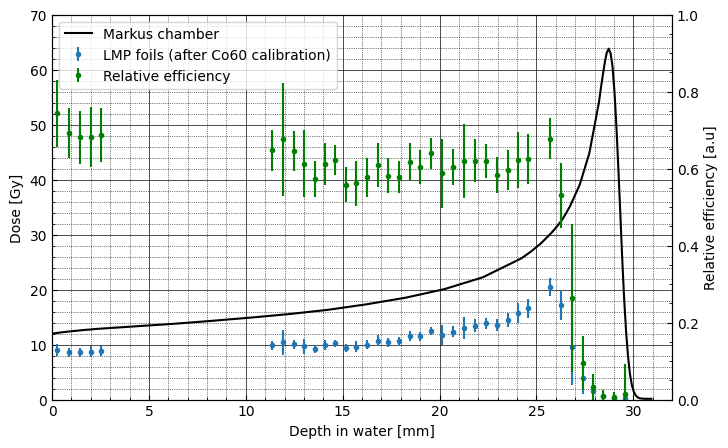

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))


ax.errorbar(df_signal_bp.pos_mm, df_signal_bp.dose_Gy_mean, yerr=df_signal_bp.dose_Gy_std, marker=".", linestyle="", label="LMP foils (after Co60 calibration)")
df_bp_exp.plot(ax=ax, x='Depth', y='dose_Gy', label='Markus chamber', color='black', style='-')
ax.set_xlabel("Depth in water [mm]")
ax.set_ylabel("Dose [Gy]")
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)
ax.set_xlim(0,32)
ax.set_ylim(0, 70)

ax_eff = ax.twinx()
ax_eff.errorbar(df_signal_bp.pos_mm, df_signal_bp.eff, yerr=df_signal_bp.eff_std, marker=".", linestyle="", color='green', label="Relative efficiency")
ax_eff.set_ylim(0,1);
ax_eff.set_ylabel('Relative efficiency [a.u]');

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_eff.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
;

# Figure 7 - BP spectra

In [20]:
df_bp_kin_en = pd.read_hdf("article-plots.h5", key="bp_kin_en")
df_bp_kin_en_spectrum = pd.read_hdf("article-plots.h5", key="bp_kin_en_spectrum")

lower_error = df_bp_kin_en.ef_q50 - df_bp_kin_en.ef_q25
upper_error = df_bp_kin_en.ef_q75 - df_bp_kin_en.ef_q50
left_error = df_bp_kin_en.z_mm - df_bp_kin_en.z_left_mm
right_error = df_bp_kin_en.z_right_mm - df_bp_kin_en.z_mm
depths_iloc = [1,6,12,-2]

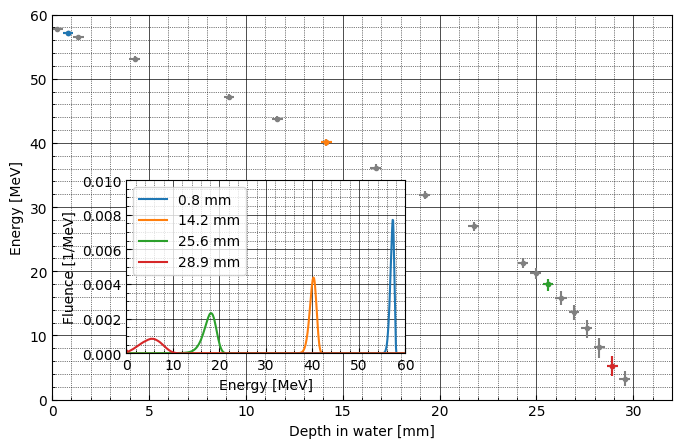

In [21]:
import mpl_toolkits
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df_bp_kin_en.z_mm, df_bp_kin_en.ef_q50, xerr=[left_error, right_error], yerr=[lower_error, upper_error], fmt='.', label='', color='grey')
for ind in depths_iloc:
    ax.errorbar([df_bp_kin_en.z_mm.iloc[ind]], [df_bp_kin_en.ef_q50.iloc[ind]], xerr=[[left_error.iloc[ind]], [right_error.iloc[ind]]], yerr=[[lower_error.iloc[ind]], [upper_error.iloc[ind]]], fmt='.', label='')    
ax.set_xlabel("Depth in water [mm]")
ax.set_ylabel("Energy [MeV]")
ax.set_xlim(0,32)
ax.set_ylim(0,60)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)

ax_inset = plt.axes([0,0,1,1])
ip = InsetPosition(ax, [0.12,0.12,0.45,0.45])
ax_inset.set_axes_locator(ip)
for z_mm in df_bp_kin_en.z_mm.iloc[depths_iloc]:
    df_tmp = df_bp_kin_en_spectrum[df_bp_kin_en_spectrum.z_mm == z_mm]
    ax_inset.plot(df_tmp.bin_middle, df_tmp.freq, label=f'{z_mm:3.1f} mm')
ax_inset.set_xlabel("Energy [MeV]")
ax_inset.set_ylabel("Fluence [1/MeV]")
ax_inset.set_xlim(0, 60)
ax_inset.set_ylim(0, 1e-2)
ax_inset.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax_inset.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)
ax_inset.legend();

# Figure 8 - efficiency fitting

In [22]:
bp_kin_en_spl = InterpolatedUnivariateSpline(df_bp_kin_en.z_mm.values, df_bp_kin_en.ef_q50.values)
df_signal_bp['ekin'] = bp_kin_en_spl(df_signal_bp.pos_mm.values)

In [23]:
import lmfit
from lmfit.models import StepModel, LinearModel
x_values_for_fit = df_signal_bp.ekin
y_values_for_fit = df_signal_bp.eff
weights = 1/df_signal_bp.eff_std
step_mod = StepModel(form='logistic')
lin_mod = LinearModel()
pars = step_mod.guess(y_values_for_fit, x=x_values_for_fit)
pars += lin_mod.guess(y_values_for_fit, x=x_values_for_fit)
pars['intercept'].value = 0
pars['intercept'].vary = False
mod = step_mod + lin_mod
out = mod.fit(y_values_for_fit, pars, x=x_values_for_fit, weights=weights)
x_for_plotting = np.linspace(0,60,num=600)
y_for_plotting = out.eval(x=x_for_plotting)
print(out.fit_report(min_correl=0.25))

[[Model]]
    (Model(step, form='logistic') + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 153
    # data points      = 38
    # variables        = 4
    chi-square         = 13.7395755
    reduced chi-square = 0.40410516
    Akaike info crit   = -30.6576192
    Bayesian info crit = -24.1072746
    R-squared          = -7.31169579
[[Variables]]
    amplitude:  0.56130013 +/- 0.02044132 (3.64%) (init = 0.7381244)
    center:     13.7250332 +/- 0.47128596 (3.43%) (init = 30.49501)
    sigma:      0.83060541 +/- 0.26850958 (32.33%) (init = 7.784977)
    slope:      0.00151932 +/- 5.5018e-04 (36.21%) (init = 0.01086422)
    intercept:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, slope) = -0.953
    C(amplitude, sigma) = 0.343
    C(sigma, slope)     = -0.326
    C(center, sigma)    = 0.288


In [24]:
# #step_mod = StepModel(form='logistic')
# step_mod = StepModel(form='arctan')
# lin_mod = LinearModel()
# pars = step_mod.guess(y_values_for_fit, x=x_values_for_fit)
# pars += lin_mod.guess(y_values_for_fit, x=x_values_for_fit)
# #pars['intercept'].min = 0
# #pars['amplitude'].min = 1e-5
# mod = step_mod + lin_mod
# out = mod.fit(y_values_for_fit, pars, x=x_values_for_fit, weights=weights)
# x_for_plotting_arctan = np.linspace(0,60,num=600)
# y_for_plotting_arctan = out.eval(x=x_for_plotting)
# print(out.fit_report(min_correl=0.25))

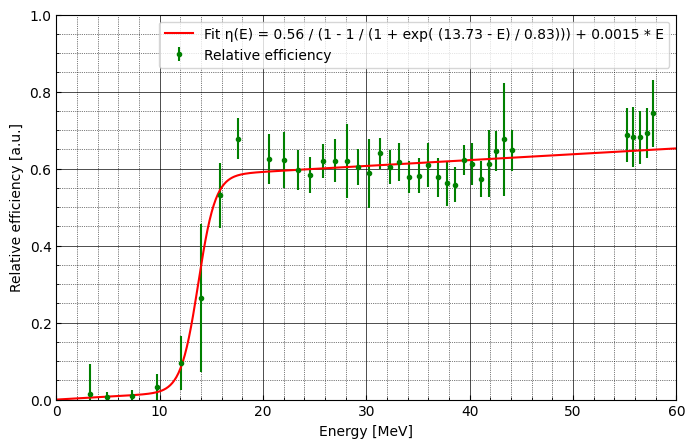

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df_signal_bp.ekin, df_signal_bp.eff, yerr=df_signal_bp.eff_std, marker=".", linestyle="", color='green', label="Relative efficiency")
# print sum of logistic function and linear function with zero intercept
A = out.best_values['amplitude']
B = out.best_values['slope']
C = out.best_values['center']
S = out.best_values['sigma']
ax.plot(x_for_plotting, y_for_plotting, color='red',
label=f"Fit η(E) = {A:3.2f} / (1 - 1 / (1 + exp( ({C:3.2f} - E) / {S:3.2f}))) + {B:3.4f} * E")
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('Relative efficiency [a.u.]')
ax.set_ylim(0,1)
ax.set_xlim(0,60)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7);
ax.legend();

# Figure 9 - BP and efficiency

In [26]:
df_signal_bp['eff_fit'] = out.eval(x=df_signal_bp.ekin)
df_signal_bp['dose_Gy_mean_fit_applied'] = df_signal_bp.dose_Gy_mean / df_signal_bp.eff_fit
df_signal_bp['dose_Gy_std_fit_applied'] = df_signal_bp.dose_Gy_std / df_signal_bp.eff_fit
df_signal_bp.dose_Gy_std_fit_applied[df_signal_bp.dose_Gy_std_fit_applied > 10] = np.nan

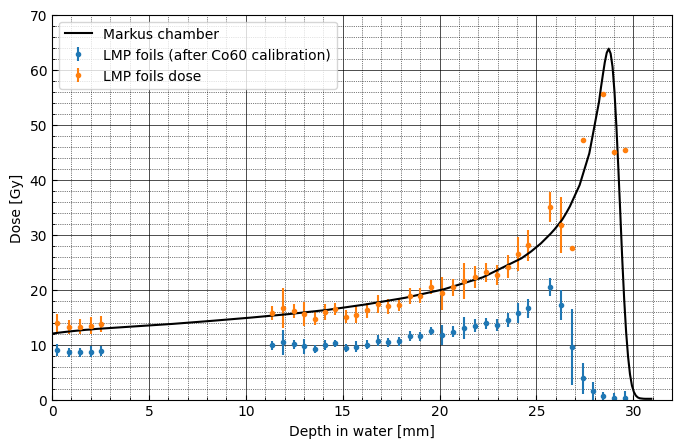

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))

df_signal_bp.plot(ax=ax, x='pos_mm', y='dose_Gy_mean', yerr='dose_Gy_std', marker=".", linestyle="", label="LMP foils (after Co60 calibration)")
df_signal_bp.plot(ax=ax, x='pos_mm', y='dose_Gy_mean_fit_applied', yerr='dose_Gy_std_fit_applied', marker=".", linestyle="", label="LMP foils dose")
df_bp_exp.plot(ax=ax, x='Depth', y='dose_Gy', label='Markus chamber', color='black', style='-')
ax.set_xlabel("Depth in water [mm]")
ax.set_ylabel("Dose [Gy]")
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)
ax.set_xlim(0,32)
ax.set_ylim(0,70)
ax.legend();

# Figure 10 - SOBP spectra

In [28]:
df_sobp_kin_en = pd.read_hdf("article-plots.h5", key="sobp_kin_en")
df_sobp_kin_en = df_sobp_kin_en[df_sobp_kin_en.z_mm < 30.5]
df_sobp_kin_en_spectrum = pd.read_hdf("article-plots.h5", key="sobp_kin_en_spectrum")

lower_error = df_sobp_kin_en.ef_q50 - df_sobp_kin_en.ef_q25
upper_error = df_sobp_kin_en.ef_q75 - df_sobp_kin_en.ef_q50
left_error = df_sobp_kin_en.z_mm - df_sobp_kin_en.z_left_mm
right_error = df_sobp_kin_en.z_right_mm - df_sobp_kin_en.z_mm
depths_iloc = [0,2,6,-5]

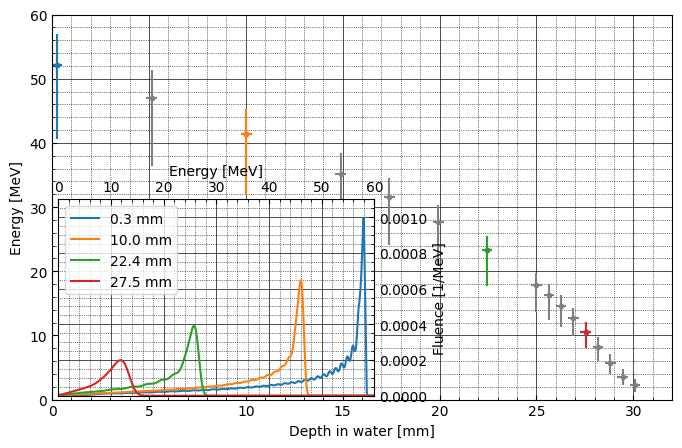

In [29]:
import mpl_toolkits
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(df_sobp_kin_en.z_mm, df_sobp_kin_en.ef_q50, xerr=[left_error, right_error], yerr=[lower_error, upper_error], fmt='.', label='', color='grey')
for ind in depths_iloc:
    ax.errorbar([df_sobp_kin_en.z_mm.iloc[ind]], [df_sobp_kin_en.ef_q50.iloc[ind]], xerr=[[left_error.iloc[ind]], [right_error.iloc[ind]]], yerr=[[lower_error.iloc[ind]], [upper_error.iloc[ind]]], fmt='.', label='')    
ax.set_xlabel("Depth in water [mm]")
ax.set_ylabel("Energy [MeV]")
ax.set_xlim(0,32)
ax.set_ylim(0,60)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)

ax_inset = plt.axes([0,0,1,1])
#ip = InsetPosition(ax, [0.12,0.12,0.45,0.45])
#ip = InsetPosition(ax, [0.55,0.55,0.44,0.44])
ip = InsetPosition(ax, [0.01,0.01,0.51,0.51])
ax_inset.set_axes_locator(ip)
for z_mm in df_sobp_kin_en.z_mm.iloc[depths_iloc]:
    df_tmp = df_sobp_kin_en_spectrum[df_sobp_kin_en_spectrum.z_mm == z_mm]
    ax_inset.plot(df_tmp.bin_middle, df_tmp.freq, label=f'{z_mm:3.1f} mm')
ax_inset.yaxis.tick_right()
ax_inset.yaxis.set_label_position("right")
ax_inset.xaxis.tick_top()
ax_inset.xaxis.set_label_position("top")
ax_inset.set_xlabel("Energy [MeV]")
ax_inset.set_ylabel("Fluence [1/MeV]")
ax_inset.set_xlim(0, 60)
ax_inset.set_ylim(0, 0.0011)
ax_inset.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax_inset.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)
ax_inset.legend();

# Figure 11 - final result

In [30]:
data_sobp = project_dir / "data" / "interim" / "foils" / "2022_11_18_sobp"
data_sobp_ids = sorted((entry.name for entry in data_sobp.iterdir() if entry.name.isdigit()), key=lambda s: int(s))
df_sobp = read_df(data_sobp, data_sobp_ids)

df_sobp["raw_data_stabilised"] = df_sobp.apply(lambda x: x.raw_data - a * (x.timestamp - df_sobp.timestamp.min()).total_seconds() , axis=1)
df_sobp["raw_mean_stabilized"] = df_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.raw_data_stabilised, tmpdf.analysis_circle)[0], axis=1)

In [31]:
df_signal_sobp = singal_df(df_sobp, df_bg=df_pre_bg, ff_array=ff_data)
df_signal_sobp["dose_Gy"] = 60. * df_signal_sobp.rotated / df_signal_ref.rotated
df_signal_sobp["dose_Gy_mean"] = df_signal_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[0], axis=1)
df_signal_sobp["dose_Gy_std"] = df_signal_sobp.apply(lambda tmpdf: get_mean_std(tmpdf.dose_Gy, tmpdf.analysis_circle_centered)[1], axis=1)
df_signal_sobp['pos_mm'] = pos_mm[::-1]
df_signal_sobp = df_signal_sobp[(df_signal_sobp.pos_mm != 25.16)]

In [32]:
sobp_kin_en_spl = InterpolatedUnivariateSpline(df_sobp_kin_en.z_mm.values, df_sobp_kin_en.ef_q50.values)
df_signal_sobp['ekin'] = sobp_kin_en_spl(df_signal_sobp.pos_mm.values)

df_signal_sobp['eff_fit'] = out.eval(x=df_signal_sobp.ekin)
df_signal_sobp['dose_Gy_mean_fit_applied'] = df_signal_sobp.dose_Gy_mean / df_signal_sobp.eff_fit
df_signal_sobp['dose_Gy_std_fit_applied'] = df_signal_sobp.dose_Gy_std / df_signal_sobp.eff_fit
df_signal_sobp.dose_Gy_std_fit_applied[df_signal_sobp.dose_Gy_std_fit_applied > 10] = np.nan

In [33]:
df_sobp_exp = pd.read_hdf("article-plots.h5", key="sobp_exp")
df_sobp_exp['dose_Gy'] = 60*df_sobp_exp.Signal.rolling(window=9, center=True).mean()

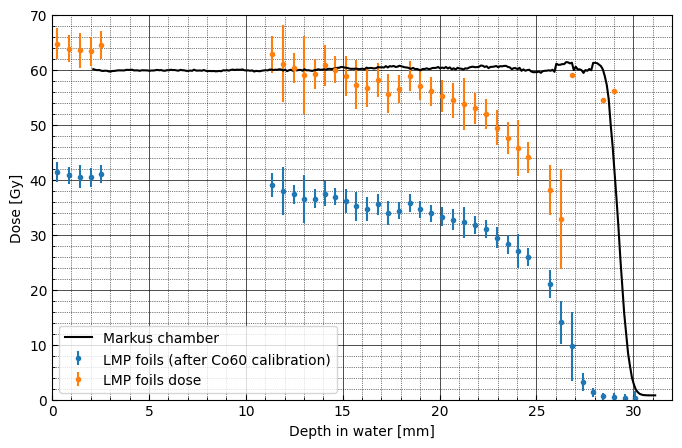

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))

df_signal_sobp.plot(ax=ax, x='pos_mm', y='dose_Gy_mean', yerr='dose_Gy_std', marker=".", linestyle="", label="LMP foils (after Co60 calibration)")
df_signal_sobp.plot(ax=ax, x='pos_mm', y='dose_Gy_mean_fit_applied', yerr='dose_Gy_std_fit_applied', marker=".", linestyle="", label="LMP foils dose")
df_sobp_exp.plot(ax=ax, x='Depth', y='dose_Gy', label='Markus chamber', color='black', style='-')
ax.set_xlabel("Depth in water [mm]")
ax.set_ylabel("Dose [Gy]")
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(which='major', linestyle='-', linewidth='0.7', color='black', alpha=0.7)
ax.set_xlim(0,32)
ax.set_ylim(0,70)
ax.legend();